# Stemwijzer

## Importing libaries

In [1]:
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import json

## Loading the JSON

In [2]:
with open('tweedekamer2025.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

In [3]:
# We flatten the 'positions' list, keeping 'theme', 'title', and 'info' as identifying metadata.
df_long = pd.json_normalize(
    data, 
    record_path='positions', 
    meta=['theme', 'title', 'info']
)

# Rename the columns for clarity before pivoting
df_long['position_col'] = df_long['party'] + '_position'
df_long['explanation_col'] = df_long['party'] + '_explanation'

# We create one table for 'position' data
df_position = df_long.pivot_table(
    index=['theme', 'title', 'info'], 
    columns='position_col', 
    values='position', 
    aggfunc='first'
).reset_index()

# We create a second table for 'explanation' data
df_explanation = df_long.pivot_table(
    index=['theme', 'title', 'info'], 
    columns='explanation_col', 
    values='explanation', 
    aggfunc='first'
).reset_index()

# We merge on the common descriptive columns: 'theme', 'title', and 'info'
df_merged = pd.merge(
    df_position, 
    df_explanation, 
    on=['theme', 'title', 'info']
)

# Sort the columns to get party columns adjacent (e.g., SP_position, SP_explanation)
party_cols = [col for col in df_merged.columns if col not in ['theme', 'title', 'info']]
party_cols.sort(key=lambda x: (x.split('_')[0], x.split('_')[1] == 'explanation'))

# Combine the descriptive columns with the sorted party columns
final_columns = ['theme', 'title', 'info'] + party_cols
df_final = df_merged[final_columns]

## A quick peek at the data

In [4]:
df_final.head()

theme  \
0  Aanwezigheid bij demonstratie   
1                        Abortus   
2        Bouwen op landbouwgrond   
3     Controle op religieuze les   
4   Eigen risico zorgverzekering   

                                               title  \
0  De politie moet bijhouden wie aanwezig is bij ...   
1      Abortus moet uit het Wetboek van Strafrecht .   
2  De regering moet het bouwen van woningen op la...   
3  De overheid moet strenger controleren wat jong...   
4  Het eigen risico bij zorgverzekeringen wordt p...   

                                                info 50PLUS_position  \
0  In Nederland heb je het recht om te demonstrer...            Eens   
1  Abortus is het afbreken van een zwangerschap d...            Eens   
2  Gemeentes die woningen willen laten bouwen, mo...            Eens   
3  De overheid heeft regels gemaakt voor scholen ...            Eens   
4  In Nederland ben je verplicht een zorgverzeker...          Oneens   

                                  50PLUS_explanation BBB_position  \
0  Betere handhaving en strenger optreden bij ove...       Oneens   
1  50PLUS ziet abortus niet als strafrecht maar m...       Oneens   
2  Als een paar % van de totale landbouwgrond voo...       Oneens   
3  Onderwijs controle wordt uitgevoerd door de in...         Eens   
4  Dit leidt tot toename koopkracht. Zeer wenseli...       Oneens   

                                     BBB_explanation BIJ1_position  \
0  Standaard moeten bijhouden wie een verboden de...        Oneens   
1  Abortus hoort in het Wetboek van Strafrecht th...          Eens   
2  Onze vruchtbare landbouwgrond is waardevol. BB...          Eens   
3  Buitenlandse mogendheden steken graag hun lang...        Oneens   
4  Het is belangrijk dat zorg toegankelijk en bet...        Oneens   

                                    BIJ1_explanation BVNL_position  ...  \
0  Iedereen moet veilig kunnen demonstreren. Het ...        Oneens  ...   
1  Abortus is een mensenrecht en hoort bij basisg...        Oneens  ...   
2  Met name de (melk)veehouderij neemt ontzettend...        Oneens  ...   
3  De surveillance van religieuze groepen belemme...          Eens  ...   
4  We zetten een Nationaal Zorgfonds op dat de pr...          Eens  ...   

  SP_position                                     SP_explanation VVD_position  \
0      Oneens  Demonstreren is een grondrecht. Iedereen heeft...         Eens   
1        Eens  Abortuszorg is zorg en hoort daarom niet thuis...         Eens   
2        Eens  De woningnood is groot en vraagt om nieuwe bou...         Eens   
3        Eens  Iedereen mag geloven wat hij wil, maar onderwi...         Eens   
4      Oneens  Het eigen risico is een boete op ziek zijn. Da...         Eens   

                                     VVD_explanation Volt_position  \
0  De VVD wil dat de politie alle mogelijkheden k...        Oneens   
1  Abortus is geen misdrijf. Als VVD vinden we he...          Eens   
2  De VVD wil flink schrappen in het aantal bouwr...          Eens   
3  Voor het aanleren van onvrije waarden is in ge...        Oneens   
4  Het eigen risico is voor ons belangrijk om de ...          Eens   

                                    Volt_explanation  \
0  Volt beschermt het recht op protest. Demonstra...   
1  Volt vindt dat vrouwen het recht hebben om ove...   
2  Volt wil sneller woningen bouwen, ook op landb...   
3  Volt staat voor gelijke behandeling. Discrimin...   
4  Volt wil dat zorg betaalbaar blijft voor ieder...   

  Vrede voor Dieren_position  \
0                     Oneens   
1                       Eens   
2                       Eens   
3                     Oneens   
4                     Oneens   

                       Vrede voor Dieren_explanation Vrij Verbond_position  \
0               Demonstratierecht is een groot goed.                Oneens   
1    Zelfbeschikking is geen misdaad maar een recht.                  Eens   
2  We willen landbouwgrond voor 90% omzetten in n...                  Eens   
3  

In [5]:
num_parties = len([col for col in df_position.columns if col.endswith('_position')])
num_issues = df_position.shape[0]

print(f"Number of parties: {num_parties}")
print(f"Number of issues: {num_issues}")

Number of parties: 24
Number of issues: 30


## What do the various parties think about each issue?

In [6]:
# List of parties in the order they appear in the image
parties = [
    'PVV', 'GroenLinks-PvdA', 'VVD', 'NSC', 'D66', 'BBB', 'CDA', 
    'SP', 'DENK', 'Partij voor de Dieren', 'FvD', 'SGP', 'ChristenUnie', 
    'Volt', 'JA21', 'Vrede voor Dieren', 'BVNL', 'BIJ1', 'Libertaire Partij', 
    '50PLUS', 'Piratenpartij', 'FNP', 'Vrij Verbond', 'De Linie'
]

# Load the image
img = Image.open('parties.png')

# Get image dimensions
width, height = img.size

# Find the logo's height:
num_parties = len(parties)
logo_height = height // num_parties

# Cut each logo and store in a dictionary
party_logos = {}
for i in range(num_parties):
    top = i * logo_height
    bottom = (i + 1) * logo_height
    logo = img.crop((0, top, width, bottom))
    party_logos[parties[i]] = logo

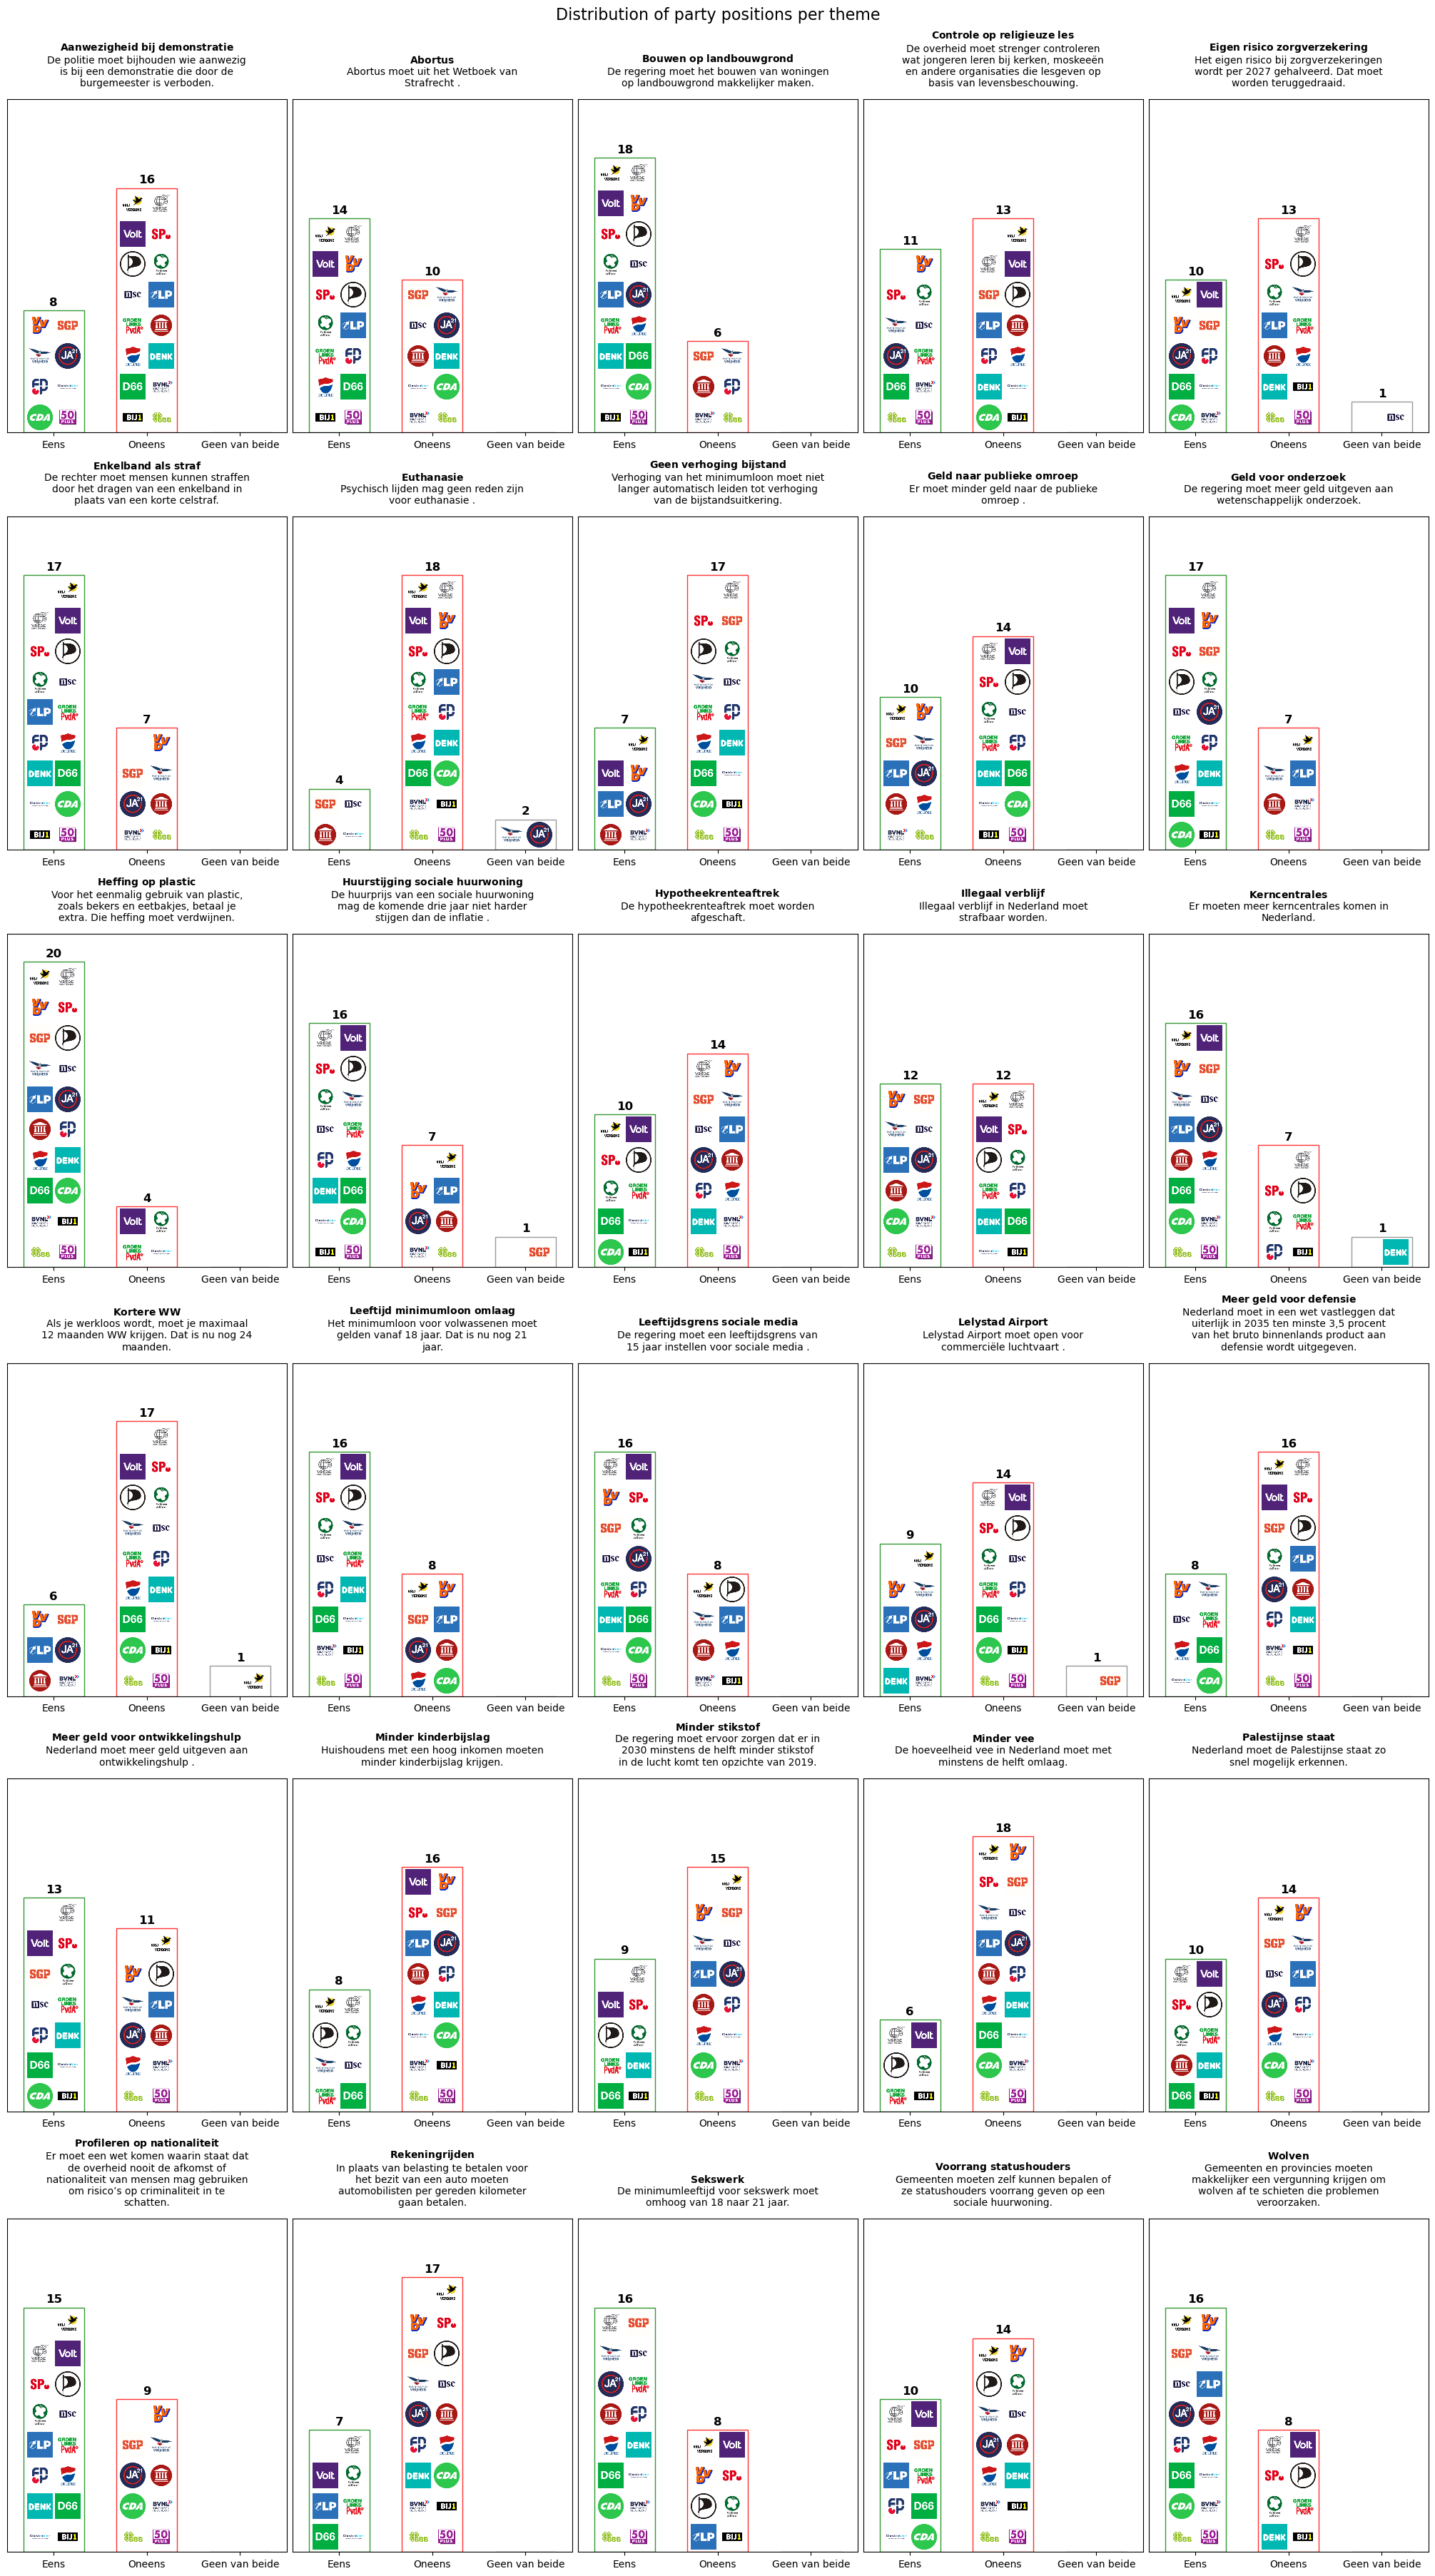

In [40]:
# Get all party position columns
position_cols = [col for col in df_position.columns if col.endswith('_position')]

# Plotting
fig, axes = plt.subplots(6, 5, figsize=(20, 36), constrained_layout=True)
axes = axes.flatten()

def text_wrap(text, width=40):
    """Wrap text at word boundaries."""
    import textwrap
    return "\n".join(textwrap.wrap(text, width=width))

def bold_text_with_spaces(text):
    """Make text bold while preserving spaces"""
    return ' '.join(f'$\\mathbf{{{word}}}$' for word in text.split())

def add_party_logos(ax, row):
    """Add party logos for each position"""
    y_offsets = [0] * 3  # Track y-offset for each column (Eens, Oneens, Geen van beide)
    
    # First, count how many parties are in each position to calculate bar heights
    counts = {'Eens': 0, 'Oneens': 0, 'Geen van beide': 0}
    for pos in [val for col, val in row.items() if col.endswith('_position')]:
        if pd.notna(pos):
            counts[pos] += 1
    
    # Draw the bars
    x = np.arange(3)
    ax.bar(x, [((counts['Eens'] + 1) // 2) * 2.2, ((counts['Oneens'] + 1) // 2) * 2.2, ((counts['Geen van beide'] + 1) // 2) * 2.2], 
           color='white', edgecolor=['green', 'red', 'grey'], alpha=0.8, width=0.65)
    # Add counts to the top of each bar (except when count is 0)
    for idx, (label, count) in enumerate(counts.items()):
        if count > 0:
            ax.text(
                idx, 
                ((count + 1) // 2) * 2.2 + 0.2, 
                str(count), 
                ha='center', 
                va='bottom', 
                fontsize=12, 
                fontweight='bold'
            )
    
    # Now add logos
    for party, pos in [(col.replace('_position', ''), val) for col, val in row.items() if col.endswith('_position')]:
        if party in party_logos and pd.notna(pos):
            if pos == 'Eens':
                x = 0
            elif pos == 'Oneens':
                x = 1
            else:  # Geen van beide
                x = 2
                
            # Convert logo to array and add to plot
            logo = party_logos[party]
            imagebox = OffsetImage(logo, zoom=0.2)
            if y_offsets[x] % 2 == 0:
                shift_x = x + 0.15
            else:
                shift_x = x - 0.15
            y = (y_offsets[x] // 2) * 2.2 + 1.1
            ab = AnnotationBbox(imagebox, (shift_x, y),
                              frameon=False,
                              box_alignment=(0.5, 0.5))
            ax.add_artist(ab)
            y_offsets[x] += 1

for i, ax in enumerate(axes):
    if i < len(df_position.index):
        row = df_position.iloc[i]
        
        # Set theme as main title and wrapped title as subtitle
        ax.set_title(
            f"{bold_text_with_spaces(row['theme'])}\n{text_wrap(row['title'])}", 
            fontsize=10, 
            pad=15,
            wrap=True
        )
        
        # Set up the axes
        ax.set_xlim(-0.5, 2.5)
        ax.set_ylim(0.0, len(position_cols))
        ax.set_xticks([0, 1, 2])
        ax.set_xticklabels(['Eens', 'Oneens', 'Geen van beide'], rotation=0)
        
        # Add party logos
        add_party_logos(ax, row)
        
        # Remove y-axis
        ax.set_yticks([])
    else:
        ax.axis('off')

plt.suptitle('Distribution of party positions per theme', fontsize=16)
plt.show()

## What reasons do parties give when they explain their positions?

In [8]:
# Ensure NLTK stopwords are downloaded and get Dutch stopwords
nltk.download('stopwords')
dutch_stopwords = set(stopwords.words('dutch'))

[nltk_data] Downloading package stopwords to /home/aswin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def generate_color_func(agree_words, disagree_words):
    """Generate a color function based on word frequencies in agree/disagree groups"""
    def color_func(word, **kwargs):
        # Get frequencies (default to 0 if word not in dict)
        agree_freq = agree_words.get(word, 0)
        disagree_freq = disagree_words.get(word, 0)
        
        # Calculate ratio (avoiding division by zero)
        total = agree_freq + disagree_freq
        if total == 0:
            return 'grey'
        
        ratio = agree_freq / total
        
        # Create RGB color based on ratio (green to red gradient)
        r = int(255 * (1 - ratio))
        g = int(255 * ratio)
        b = 0
        
        return f'rgb({r}, {g}, {b})'
    return color_func

def create_word_frequencies(text_list):
    """Create word frequency dictionary from list of texts"""
    from collections import Counter
    import string
    
    # Create translation table to remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    
    words = []
    for text in text_list:
        if isinstance(text, str):
            # Remove punctuation and split into words
            clean_text = text.translate(translator)
            # Split text into words and filter out stopwords
            words.extend([word.lower() for word in clean_text.split() 
                         if word.lower() not in dutch_stopwords 
                         and len(word) > 2])
    return Counter(words)

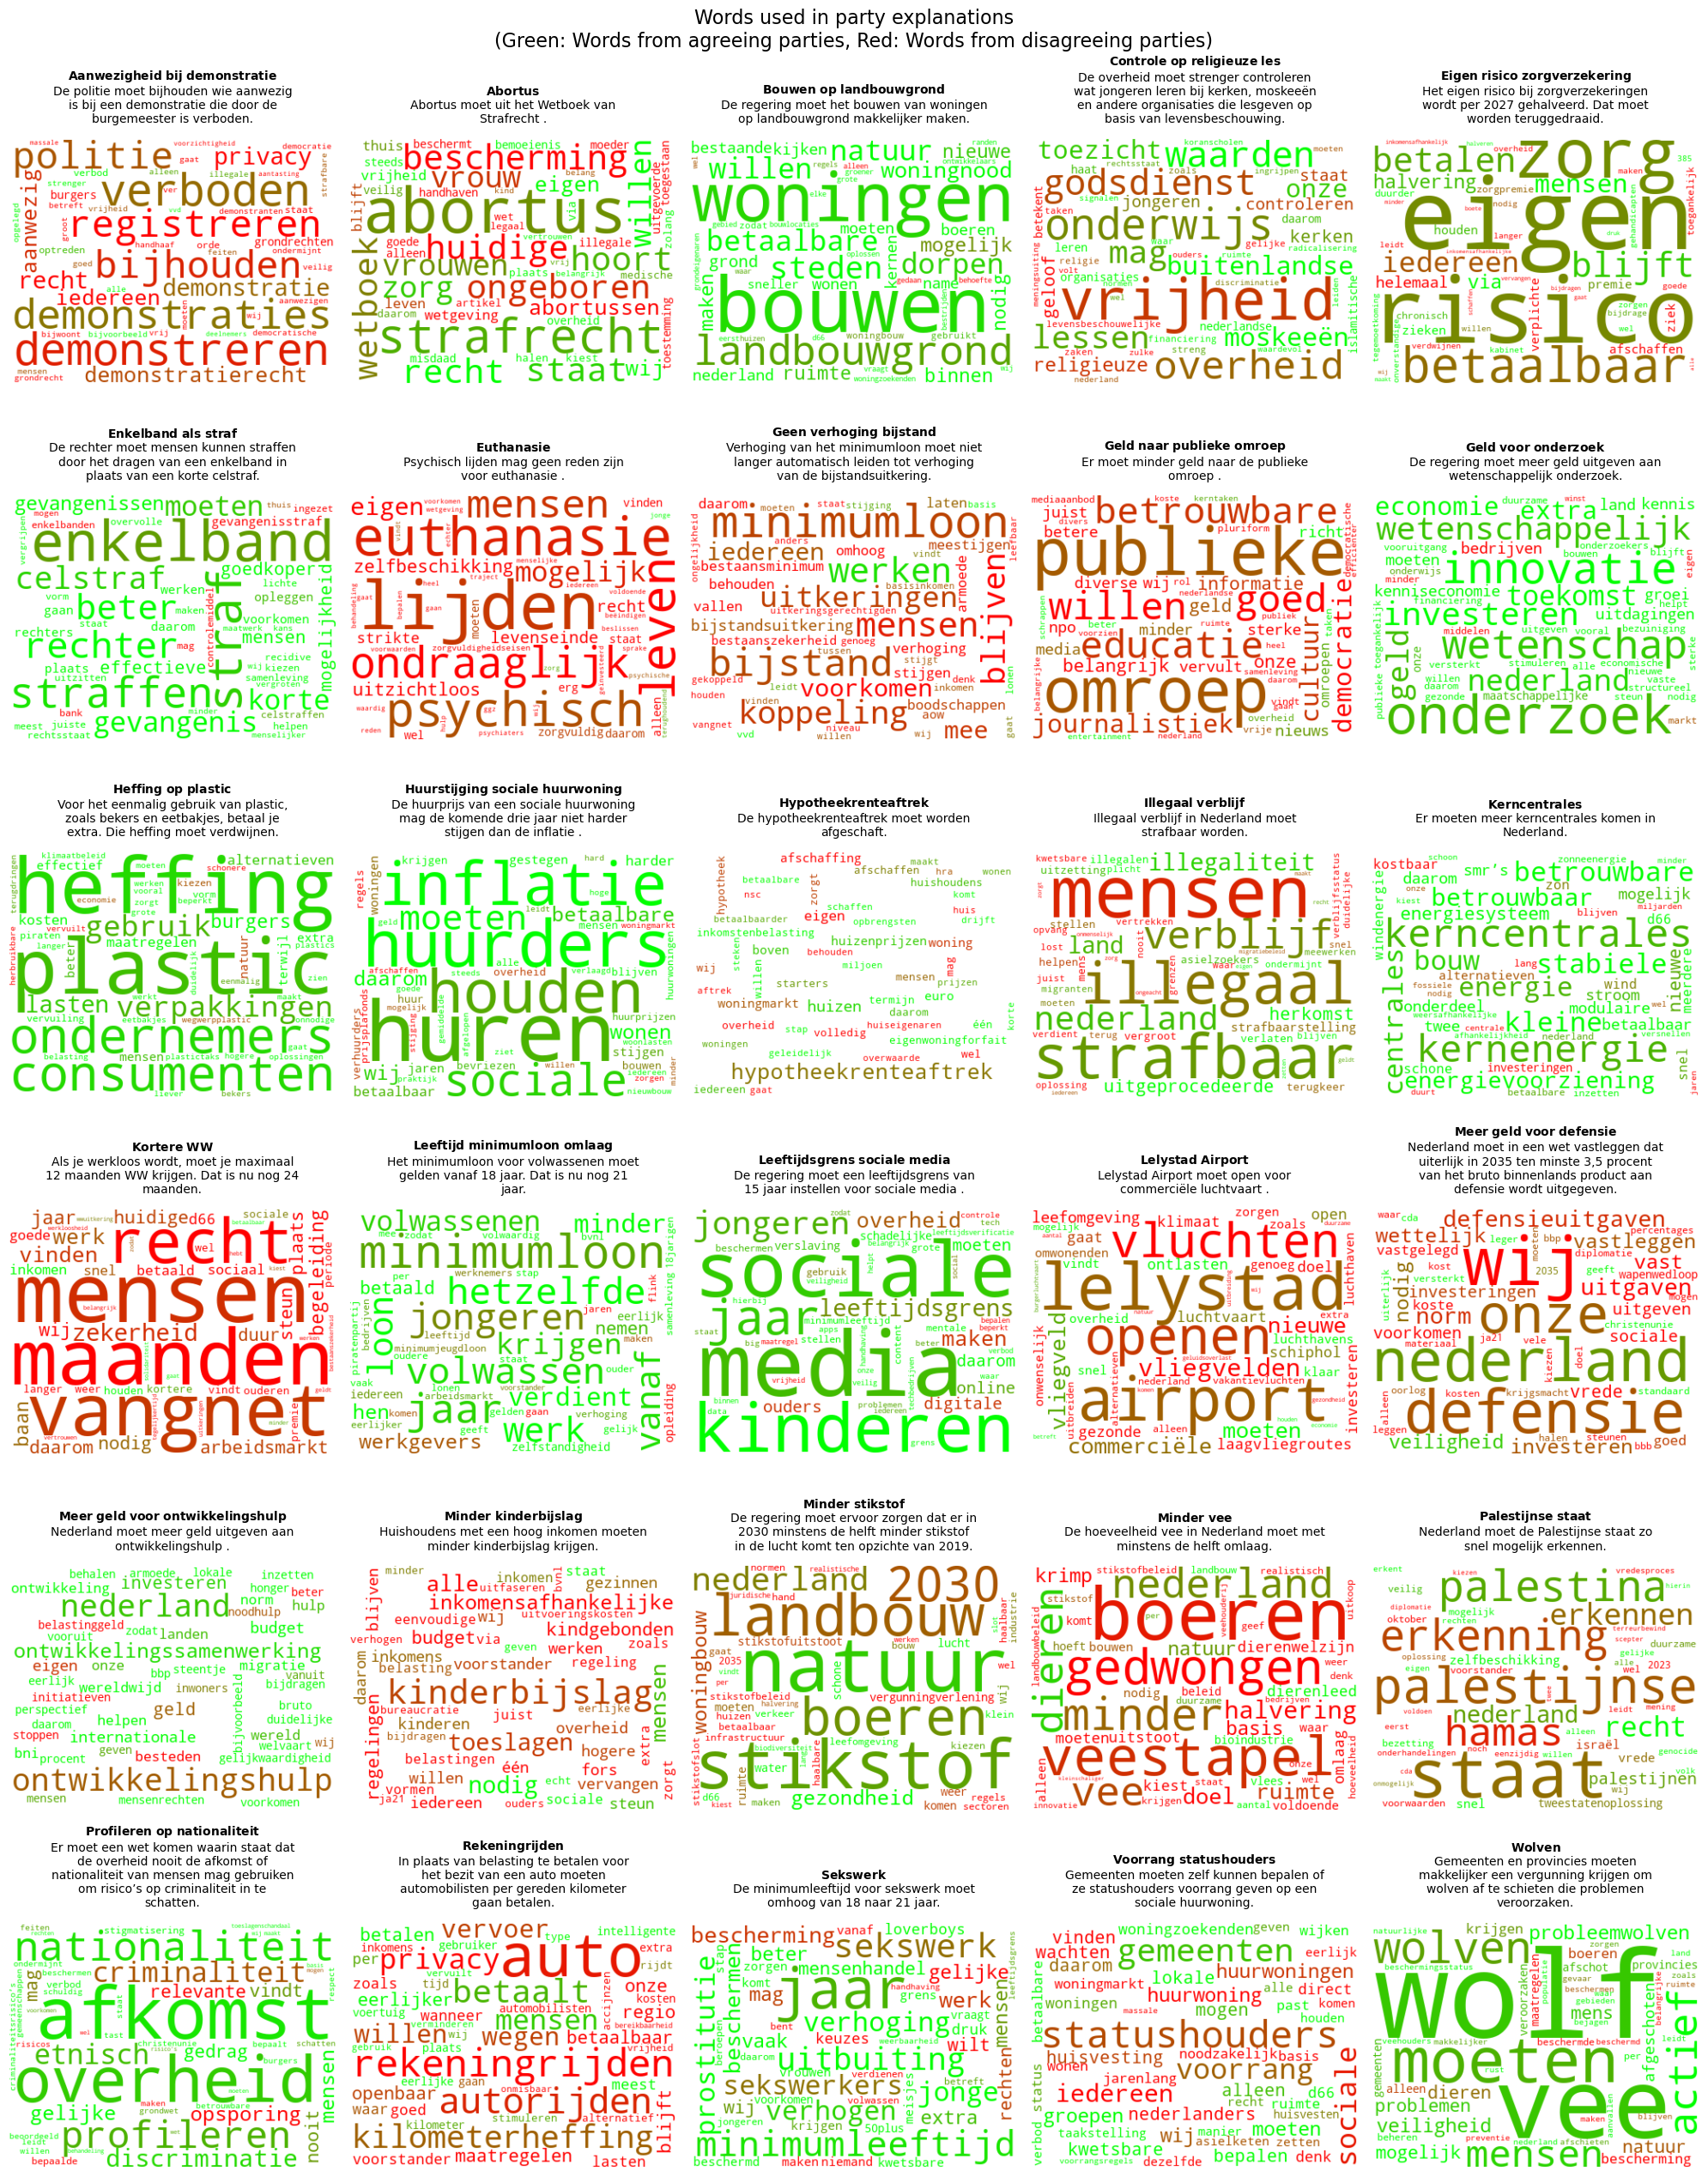

In [39]:
# Create word clouds for each issue
fig, axes = plt.subplots(6, 5, figsize=(20, 26))
axes = axes.flatten()

for idx, (_, row) in enumerate(df_final.iterrows()):
    if idx >= len(axes):
        break
        
    # Get explanations for parties that agree and disagree
    agree_explanations = []
    disagree_explanations = []
    
    for party in parties:
        pos_col = f'{party}_position'
        exp_col = f'{party}_explanation'
        
        if pos_col in row and exp_col in row and pd.notna(row[pos_col]) and pd.notna(row[exp_col]):
            if row[pos_col] == 'Eens':
                agree_explanations.append(row[exp_col])
            elif row[pos_col] == 'Oneens':
                disagree_explanations.append(row[exp_col])
    
    # Create word frequencies for each group
    agree_words = create_word_frequencies(agree_explanations)
    disagree_words = create_word_frequencies(disagree_explanations)
    
    # Combine all words for the word cloud
    all_words = {}
    for word in set(list(agree_words.keys()) + list(disagree_words.keys())):
        all_words[word] = max(agree_words.get(word, 0), disagree_words.get(word, 0))
    
    if all_words:  # Only create word cloud if we have words
        # Create and generate word cloud
        wc = WordCloud(width=400, height=300, background_color='white', 
                      color_func=generate_color_func(agree_words, disagree_words),
                      max_words=50)
        wc.generate_from_frequencies(all_words)
        
        # Display word cloud
        axes[idx].imshow(wc, interpolation='bilinear')
        axes[idx].axis('off')
        axes[idx].set_title(
            f"{bold_text_with_spaces(row['theme'])}\n{text_wrap(row['title'])}", 
            fontsize=10, 
            pad=15,
            wrap=True
        )

# Remove empty subplots
for idx in range(len(df_final), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Words used in party explanations\n(Green: Words from agreeing parties, Red: Words from disagreeing parties)', 
             fontsize=16, y=0.99)
plt.tight_layout()
plt.show()

## How similarly do parties answer across all 30 statements? 

In [11]:
# Get the raw positions (without encoding)
df_positions = df_position[position_cols]

# Clean up party names by removing '_position' suffix
party_names = [col.replace('_position', '') for col in position_cols]

# Initialize agreement matrix with zeros, explicitly setting dtype to float64
agreement_matrix = pd.DataFrame(0.0, index=party_names, columns=party_names, dtype='float64')

# Calculate agreement percentages
for i, party1 in enumerate(position_cols):
    for j, party2 in enumerate(position_cols):
        # Get positions for both parties where neither is null
        mask = df_positions[party1].notna() & df_positions[party2].notna()
        positions1 = df_positions[party1][mask]
        positions2 = df_positions[party2][mask]
        
        if len(positions1) > 0:  # Only calculate if we have valid positions
            # Count where both agree:
            # - both Eens
            # - both Oneens
            # - both Geen van beide
            agreements = ((positions1 == 'Eens') & (positions2 == 'Eens')) | \
                        ((positions1 == 'Oneens') & (positions2 == 'Oneens')) | \
                        ((positions1 == 'Geen van beide') & (positions2 == 'Geen van beide'))
            
            # Calculate percentage
            agreement_pct = (agreements.sum() / len(positions1)) * 100
            
            # Store in matrix using cleaned party names
            agreement_matrix.iloc[i, j] = agreement_pct

# Round to 1 decimal place
agreement_matrix = agreement_matrix.round(1)

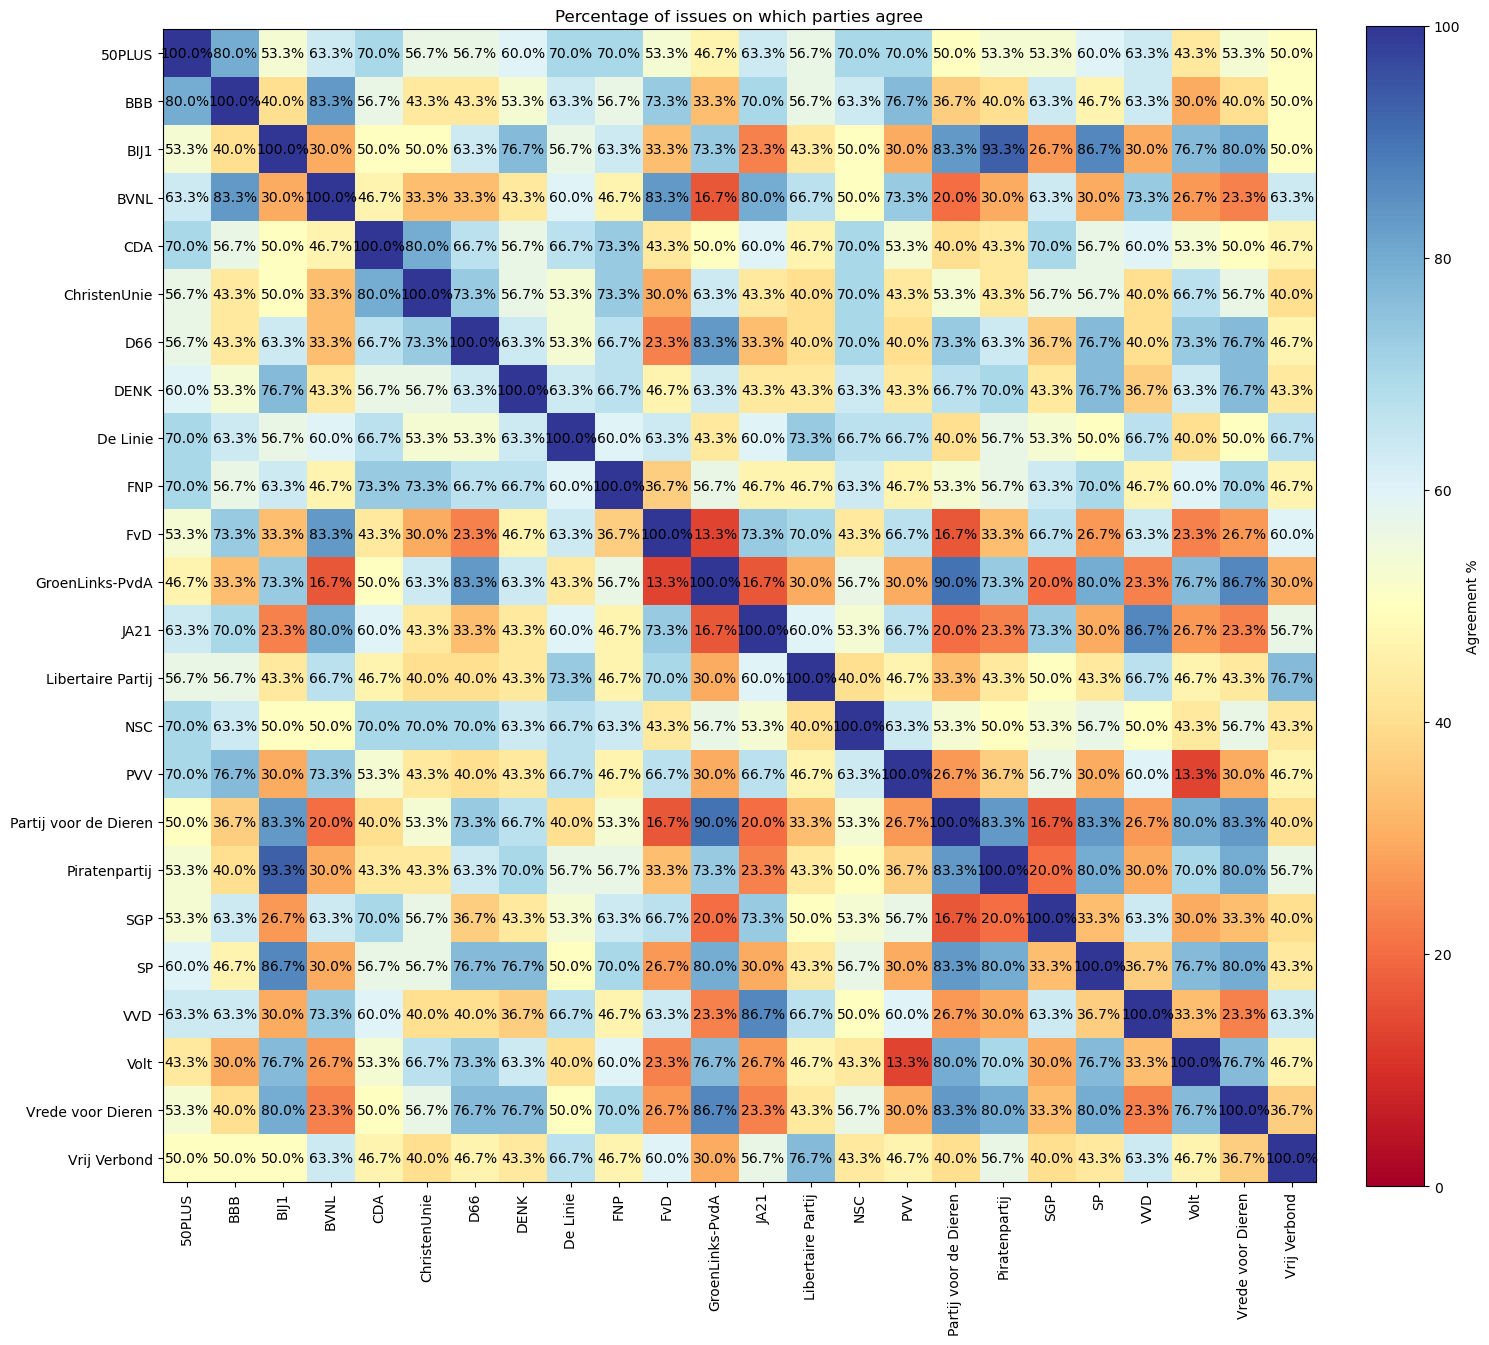

In [38]:
plt.figure(figsize=(15, 15))
im = plt.imshow(agreement_matrix, cmap='RdYlBu', vmin=0, vmax=100)
plt.colorbar(im, fraction=0.046, pad=0.04, label='Agreement %')
plt.xticks(range(len(party_names)), party_names, rotation=90)
plt.yticks(range(len(party_names)), party_names)
plt.title('Percentage of issues on which parties agree')

# Add percentage text to each cell
for i in range(len(party_names)):
    for j in range(len(party_names)):
        text = plt.text(j, i, f'{agreement_matrix.iloc[i, j]}%',
                       ha='center', va='center')
        
plt.tight_layout()
plt.show()

## What parties are the most and the least in agreement with each other?

In [13]:
min_agreement = agreement_matrix.values.min()

# Find the second largest unique agreement value
unique_agreements = np.unique(agreement_matrix.values)
if len(unique_agreements) > 1:
    max_agreement = unique_agreements[-2]
else:
    max_agreement = unique_agreements[0]

print(f"Minimal agreement percentage: {min_agreement}%")
print(f"Maximal agreement percentage: {max_agreement}%")

Minimal agreement percentage: 13.3%
Maximal agreement percentage: 93.3%


In [14]:
# Find all party pairs with the second largest agreement
second_max_pairs = []
for i in range(len(party_names)):
    for j in range(i + 1, len(party_names)):
        if agreement_matrix.iloc[i, j] == max_agreement:
            second_max_pairs.append((party_names[i], party_names[j]))

for p1, p2 in second_max_pairs:
    print(f"{p1} ❤️ {p2}: {max_agreement}%")

BIJ1 ❤️ Piratenpartij: 93.3%


In [15]:

# Find party pairs for min_agreement
party_pairs = []
for i in range(len(party_names)):
    for j in range(i + 1, len(party_names)):
        value = agreement_matrix.iloc[i, j]
        if value == min_agreement:
            party_pairs.append((party_names[i], party_names[j]))

for p1, p2 in party_pairs:
    print(f"{p1} 💔 {p2}: {min_agreement}%")

FvD 💔 GroenLinks-PvdA: 13.3%
PVV 💔 Volt: 13.3%


## Squeezing 30 issues into 2D using t-SNE

In [16]:
pd.set_option('future.no_silent_downcasting', True)

# Create encoded dataframe by mapping positions to numerical values
position_mapping = {
    'Eens': 1.0,
    'Oneens': -1.0,
    'Geen van beide': 0.0
}

# Get only the position columns and convert to numeric values
position_cols = [col for col in df_position.columns if col.endswith('_position')]
df_encoded = df_position[position_cols].copy()
df_encoded = df_encoded.replace(position_mapping)

# Convert to float64
df_encoded = df_encoded.astype('float64')

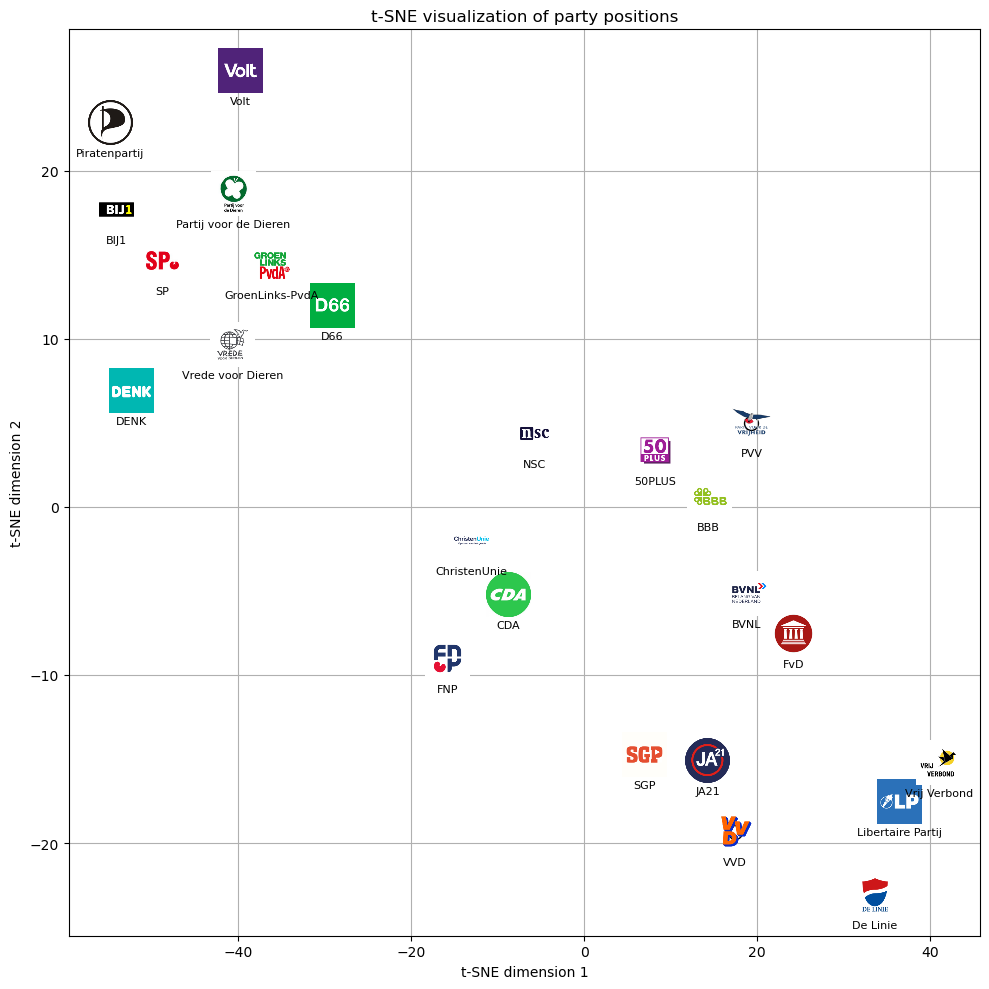

In [47]:
# Prepare the encoded party positions
X = df_encoded.values

# Run t-SNE
tsne = TSNE(n_components=2, random_state=4, perplexity=5)
X_embedded = tsne.fit_transform(X.T)  # transpose so shape is (n_parties, n_issues)

# Plot the parties in 2D space
plt.figure(figsize=(10, 10))

# Add party logos and points
for i, name in enumerate(party_names):
    # Add the scatter point
    plt.scatter(X_embedded[i, 0], X_embedded[i, 1], color='white', edgecolor='black', s=100)
    
    # Add the party logo
    if name in party_logos:
        imagebox = OffsetImage(party_logos[name], zoom=0.25)
        ab = AnnotationBbox(imagebox, (X_embedded[i, 0], X_embedded[i, 1]),
                          frameon=False,
                          box_alignment=(0.5, 0.5))
        plt.gca().add_artist(ab)
    
    # Add party name below the logo
    plt.text(X_embedded[i, 0], X_embedded[i, 1] - 1.5, name, 
             fontsize=8, ha='center', va='top')

plt.title('t-SNE visualization of party positions')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.grid(True)
plt.tight_layout()
plt.show()

## Doing a Principal Component Analysis (PCA)

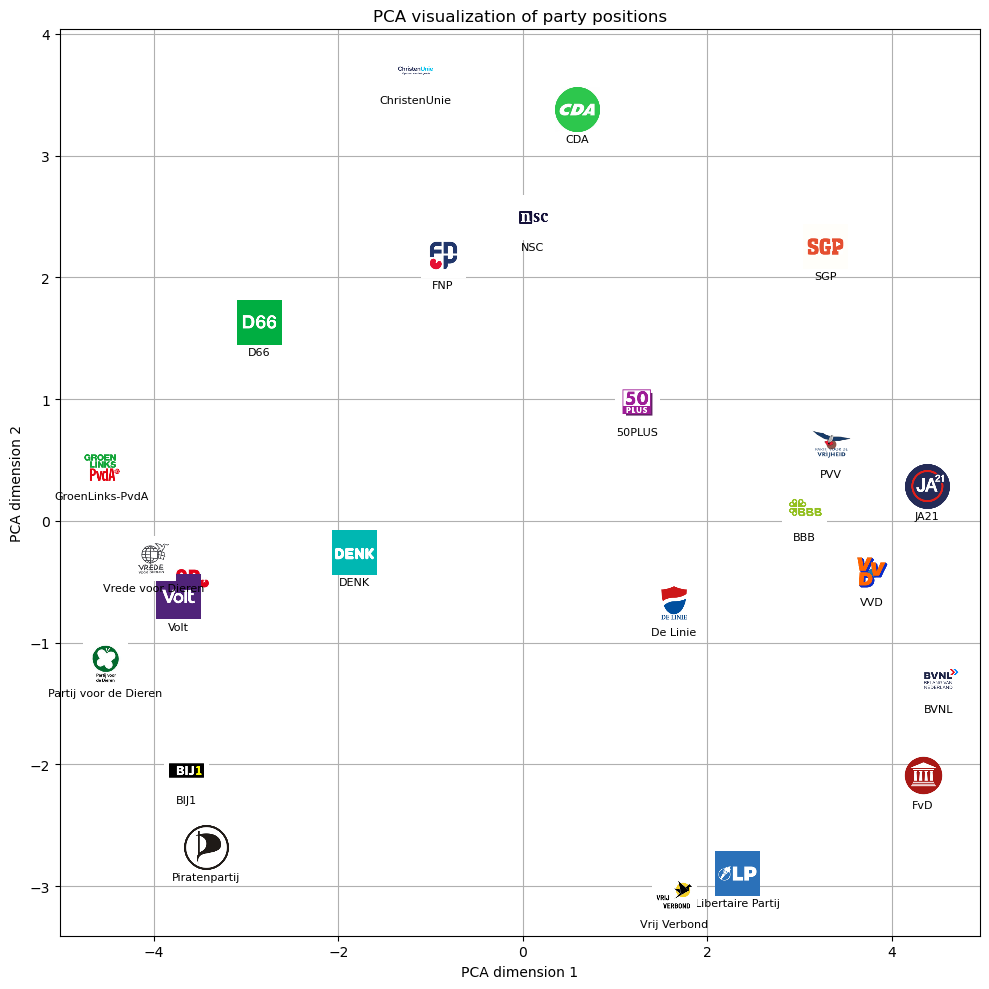

In [46]:
# Prepare the encoded party positions (already created in cell 13)
X = df_encoded.values

# Run PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.T)  # transpose so shape is (n_parties, n_issues)

# Plot the parties in 2D space
plt.figure(figsize=(10, 10))
for i, name in enumerate(party_names):
    plt.scatter(X_pca[i, 0], X_pca[i, 1])

    # Add the party logo
    if name in party_logos:
        imagebox = OffsetImage(party_logos[name], zoom=0.25)
        ab = AnnotationBbox(imagebox, (X_pca[i, 0], X_pca[i, 1]),
                          frameon=False,
                          box_alignment=(0.5, 0.5))
        plt.gca().add_artist(ab)
    
    # Add party name below the logo
    plt.text(X_pca[i, 0], X_pca[i, 1] - 0.20, name, 
             fontsize=8, ha='center', va='top')

plt.title('PCA visualization of party positions')
plt.xlabel('PCA dimension 1')
plt.ylabel('PCA dimension 2')
plt.grid(True)
plt.tight_layout()
plt.show()

## How much variance do components capture?

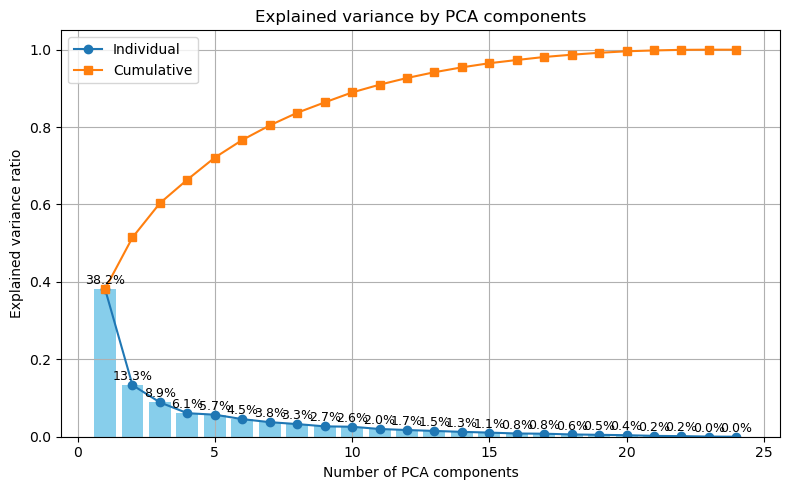

In [35]:
# Fit PCA with all possible components (up to number of parties)
pca_full = PCA(n_components=len(position_cols), random_state=42)
X = df_encoded.values
pca_full.fit(X.T)  # shape: (n_parties, n_issues)

# Explained variance ratio for each component
explained_variance = pca_full.explained_variance_ratio_

# Plot the explained variance ratio
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', label='Individual')
plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='s', label='Cumulative')
plt.xlabel('Number of PCA components')
plt.ylabel('Explained variance ratio')

# Annotate each bar with the percentage of explained variance
for i, v in enumerate(explained_variance):
    plt.text(i + 1, v + 0.005, f"{v*100:.1f}%", ha='center', va='bottom', fontsize=9)
plt.bar(range(1, len(explained_variance) + 1), explained_variance, color='skyblue')
plt.legend().remove()
plt.title('Explained variance by PCA components')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Interpreting the axes

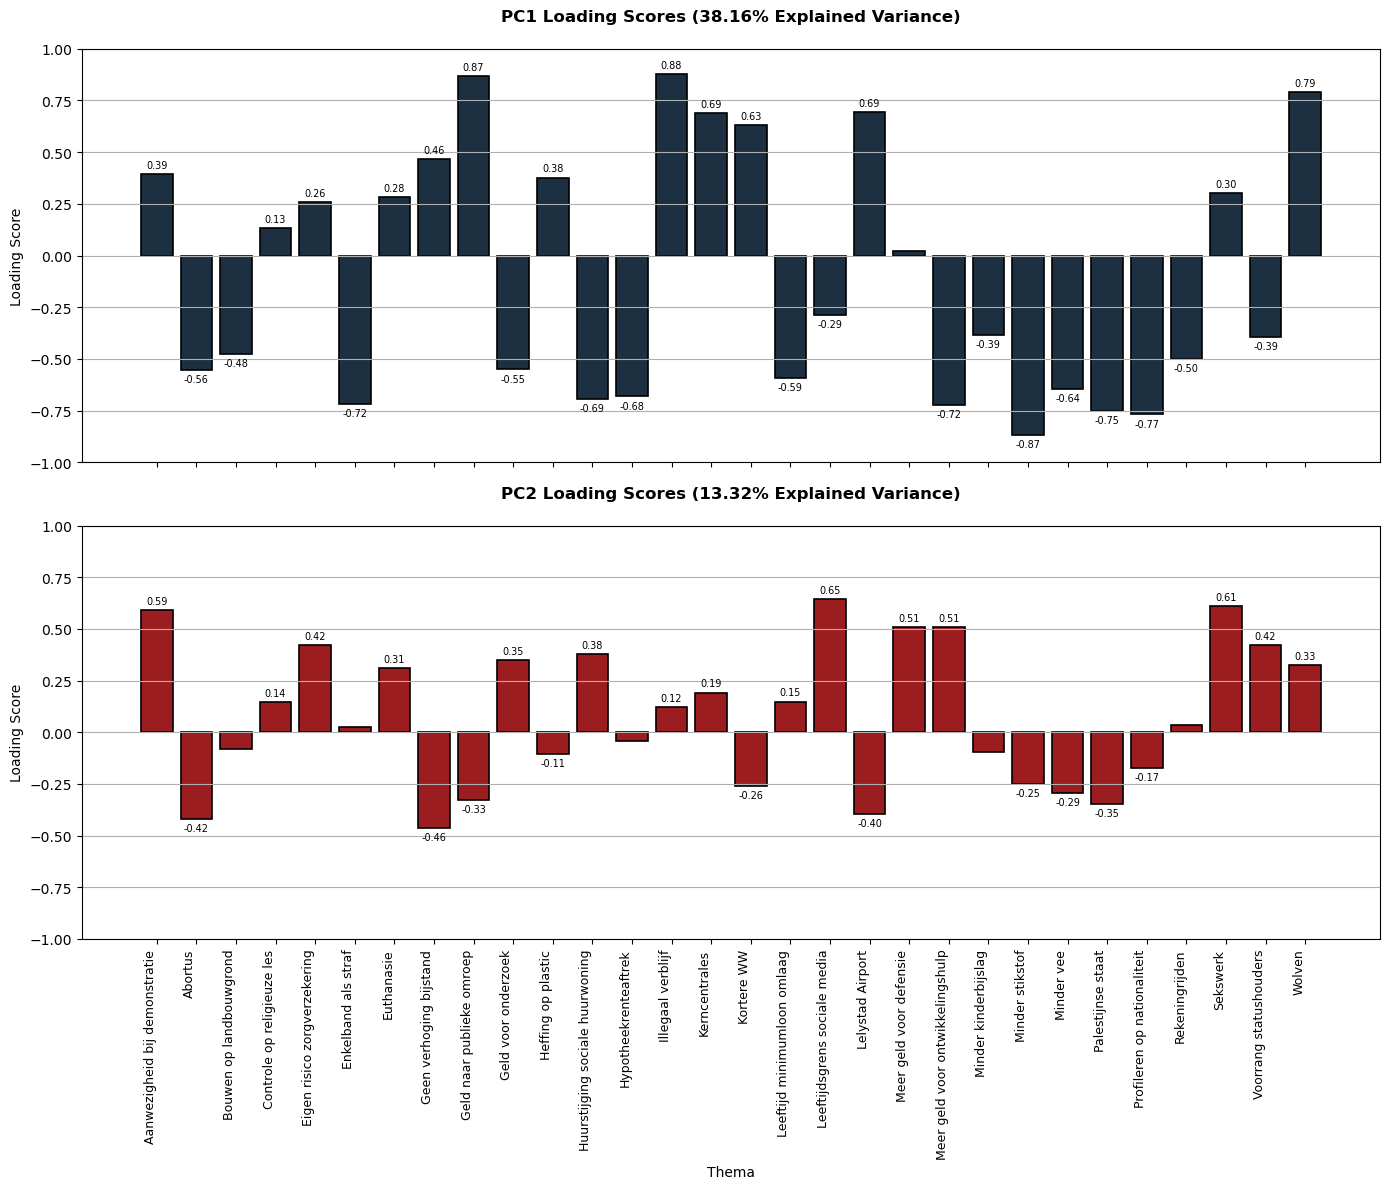

In [ ]:
# Get PCA loadings (components) for each issue on each factor
# Create DataFrame with loadings scaled by explained variance
loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns=[f"PC{i}" for i in range(1, pca.n_components_ + 1)],
    index=df_position['theme']
)

fig, axs = plt.subplots(2, 1, figsize=(14, 12), sharex=True, sharey=True)
colors = ["#1C3041", "#9B1D20"]

for i, ax in enumerate(axs):
    if i >= pca.n_components_:
        ax.axis('off')
        continue
        
    explained_variance = pca.explained_variance_ratio_[i] * 100
    pc = f"PC{i+1}"
    bars = ax.bar(range(len(loadings.index)), loadings[pc], color=colors[i], edgecolor="#000000", linewidth=1.2)
    ax.set_title(f"{pc} Loading Scores ({explained_variance:.2f}% Explained Variance)", fontdict={"weight": "bold"}, pad=20)
    if i == len(axs) - 1:  # Only add xlabel to the bottom subplot
        ax.set_xlabel("Thema")
    ax.set_ylabel("Loading Score")
    ax.grid(axis="y")
    ax.set_xticks(range(len(loadings.index)))
    if i == len(axs) - 1:  # Only add x-tick labels to the bottom subplot
        ax.set_xticklabels(loadings.index, rotation=90, ha='right', fontsize=9)
    ax.set_ylim(-1, 1)
    
    for j, bar in enumerate(bars):
        yval = bar.get_height()
        if abs(yval) > 0.1:  # Only show labels for significant values
            offset = yval + 0.02 if yval > 0 else yval - 0.02
            ax.text(bar.get_x() + bar.get_width() / 2, offset, f"{yval:.2f}", 
                   ha="center", va="bottom" if yval > 0 else "top", fontsize=7)

plt.tight_layout()
plt.show()

In [43]:
# Get absolute loadings for PC1 and PC2
pc1_loadings = loadings['PC1'].abs()
pc2_loadings = loadings['PC2'].abs()

# Get top 5 themes for each component
top5_pc1 = pc1_loadings.sort_values(ascending=False).head(5)
top5_pc2 = pc2_loadings.sort_values(ascending=False).head(5)

print("Top 5 most important themes for PC1:")
for theme in top5_pc1.index:
    print(f"- {theme} (loading: {loadings.loc[theme, 'PC1']:.2f})")

print("\nTop 5 most important themes for PC2:")
for theme in top5_pc2.index:
    print(f"- {theme} (loading: {loadings.loc[theme, 'PC2']:.2f})")

Top 5 most important themes for PC1:
- Illegaal verblijf (loading: 0.88)
- Geld naar publieke omroep (loading: 0.87)
- Minder stikstof (loading: -0.87)
- Wolven (loading: 0.79)
- Profileren op nationaliteit (loading: -0.77)

Top 5 most important themes for PC2:
- Leeftijdsgrens sociale media (loading: 0.65)
- Sekswerk (loading: 0.61)
- Aanwezigheid bij demonstratie (loading: 0.59)
- Meer geld voor defensie (loading: 0.51)
- Meer geld voor ontwikkelingshulp (loading: 0.51)


PC1 seems to represent a _Left-Right_ ideological spectrum. PC2 can be interpreted as an _Authoritarian–Libertarian_ dimension.